In [101]:
import sys; sys.path.append('../util')
from load_yelp_data import load_yelp_dataframe, restaurants_and_bars_in, train_test_split_reviews
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn as sk
import sklearn.linear_model
from sklearn.model_selection import train_test_split
# import graphlab as gl
import sklearn.metrics
import ast
%matplotlib inline

from matrix_factorization_recommender import MatrixFactorizationRecommender
from simple_averaging_recommender import SimpleAveragingRecommender

In [102]:
businesses = load_yelp_dataframe('businesses')
reviews = load_yelp_dataframe('reviews')
users = load_yelp_dataframe('users')

phoenix_restaurants, phoenix_reviews, phoenix_users = restaurants_and_bars_in('Phoenix', businesses, reviews, users)
reviews_train, reviews_test = train_test_split_reviews(phoenix_reviews)

In [103]:
phoenix_restaurants.head(2)

,attributes,business_id,categories,city,full_address,hours,latitude,longitude,name,neighborhoods,open,review_count,stars,state,type,location
2377,"{'Accepts Credit Cards': True, 'Noise Level': ...",2377,"['Sandwiches', 'Pizza', 'Chicken Wings', 'Rest...",Phoenix,"2819 N Central Ave\nPhoenix, AZ 85004","{'Monday': {'close': '00:00', 'open': '10:00'}...",33.479482,-112.073681,Domino's Pizza,[],True,20,3.0,AZ,business,Phoenix
2378,"{'Accepts Credit Cards': True, 'Noise Level': ...",2378,"['American (New)', 'Sandwiches', 'Restaurants']",Phoenix,"1850 N Central Ave\nPhoenix, AZ 85004",{},33.468547,-112.075085,Viad Tower Restaurants,[],True,6,3.5,AZ,business,Phoenix


### clean the data

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1432ac890>]], dtype=object)

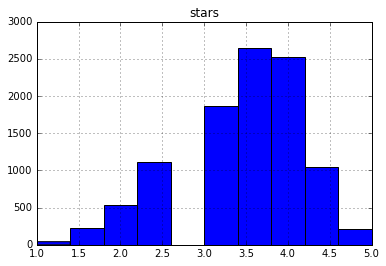

In [104]:
phoenix_restaurants.hist('stars')

Note: looks almost normal!! Wooop

In [135]:
# phoenix_restaurants, phoenix_reviews, phoenix_users = restaurants_and_bars_in('Phoenix', businesses, reviews, users)
# interesting columns
columns_of_interest = ['business_id',
                     'attributes',
                     'categories',
                     'city',
#                      'hours', # looks complicated
                     'latitude',
                     'longitude',
                     'neighborhoods',
                     'open',
                     'review_count',
                     'stars']
phoenix_restaurants = phoenix_restaurants[columns_of_interest]

def flatten(dct, separator='_'):
    """A fast way to flatten a dictionary,"""
    res = {}
    queue = [('', dct)]

    while queue:
        prefix, d = queue.pop()
        for k, v in d.items():
            key = prefix + k
            if not isinstance(v, dict):
                res[key] = [v]
            else:
                queue.append((key + separator, v))
    return res

def parse_data(row):
    attribs = flatten(ast.literal_eval(row.attributes))
    categories = ast.literal_eval(row.categories)
    neighborhoods = ast.literal_eval(row.neighborhoods)
    attributes = pd.DataFrame.from_dict(attribs, orient='columns')
    categories = pd.DataFrame.from_dict(dict([[c, [1]] for c in categories]))
    neighborhoods = pd.DataFrame.from_dict(dict([[n, [1]] for n in neighborhoods]))
    
    row = row.drop(['attributes', 'categories', 'neighborhoods'])
    if (neighborhoods.shape[0] > 0) & (attributes.shape[0] > 0):
        result = pd.concat((row, categories.iloc[0], neighborhoods.iloc[0], pd.get_dummies(attributes).iloc[0]), axis=0)
    elif (neighborhoods.shape[0] > 0):
        result = pd.concat((row, categories.iloc[0], neighborhoods.iloc[0]), axis=0)
    elif (attributes.shape[0] > 0):
        result = pd.concat((row, categories.iloc[0], pd.get_dummies(attributes).iloc[0]), axis=0)
    else:
        result = pd.concat((row, categories.iloc[0]), axis=0)
    return result

phoenix_update = phoenix_restaurants.apply(parse_data,axis=1,)
phoenix_update = pd.concat((phoenix_update, pd.get_dummies(phoenix_update['city'])), axis=1)
phoenix_update = phoenix_update.drop('city', axis=1)
phoenix_update = phoenix_update.fillna(0)
phoenix_update.head(2)

,Accepts Credit Cards,Accepts Insurance,Active Life,Adult Entertainment,Afghan,African,Ages Allowed_18plus,Ages Allowed_21plus,Ages Allowed_allages,Airport Lounges,...,Surprise,Tempe,Tolleson,Tonopah,Tonto Basin,Tortilla Flat,Wickenburg,Youngtown,glendale,phoenix
2377,True,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2378,True,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [136]:
phoenix_update['business_id'].shape

(10182,)

In [109]:
phoenix_update.head(2)

,Accepts Credit Cards,Accepts Insurance,Active Life,Adult Entertainment,Afghan,African,Ages Allowed_18plus,Ages Allowed_21plus,Ages Allowed_allages,Ahwatukee,...,Yoga,Youngtown,business_id,glendale,latitude,longitude,open,phoenix,review_count,stars
2377,True,0,0,0,0,0,0,0,0,0,...,0,0,2377,0,33.479482,-112.073681,True,0,20,3.0
2378,True,0,0,0,0,0,0,0,0,0,...,0,0,2378,0,33.468547,-112.075085,True,0,6,3.5


In [34]:
las = sklearn.linear_model.Lasso(alpha=10**(-2.5))
las.fit(phoenix_update.drop('stars', axis=1), phoenix_update['stars'].values)
las.coef_

array([ -0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
        -0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
        -0.00000000e+00,  -0.00000000e+00,  -0.00000000e+00,
        -0.00000000e+00,  -0.00000000e+00,   8.93067089e-02,
        -4.04754354e-02,   3.81984824e-02,   0.00000000e+00,
         0.00000000e+00,   2.73929456e-02,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,  -0.00000000e+00,
        -0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
        -4.64273422e-02,   0.00000000e+00,  -0.00000000e+00,
         0.00000000e+00,  -0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,  -0.00000000e+00,   0.00000000e+00,
        -0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
        -0.00000000e+00,  -5.32875569e-02,   0.00000000e+00,
        -0.00000000e+00,  -0.00000000e+00,   0.00000000e+00,
        -0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,  -0.00000000e+00,
        -0.00000000e+00,

In [35]:
x = phoenix_update.drop('stars', axis=1)
x.columns[las.coef_ > 0]

Index([u'Alcohol_beer_and_wine', u'Alcohol_none', u'Ambience_divey', u'Caters',
       u'Food', u'Good For Groups', u'Good For_lunch', u'Noise Level_average',
       u'Noise Level_quiet', u'Outdoor Seating', u'Parking_lot',
       u'Takes Reservations', u'Wheelchair Accessible', u'business_id',
       u'latitude', u'review_count'],
      dtype='object')

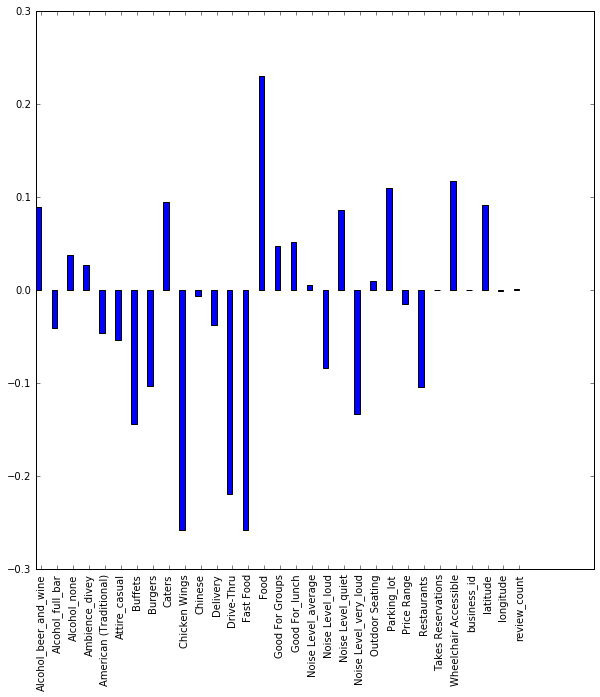

In [36]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
ind = np.arange(len(las.coef_[las.coef_ != 0]))
width = 0.35
ax.bar(ind, las.coef_[las.coef_ != 0], width)
ax.set_xticks(ind + width)
ax.set_xticklabels(x.columns[las.coef_ != 0])
plt.setp(ax.get_xticklabels(), rotation=90, fontsize=10)
plt.show()

In [38]:
scores = []
i_vals = np.logspace(-5,5,15)
for i in i_vals:
    las = sklearn.linear_model.Ridge(alpha=i)
    las.fit(X_train, y_train)
    scores.append(las.score(X_test, y_test))

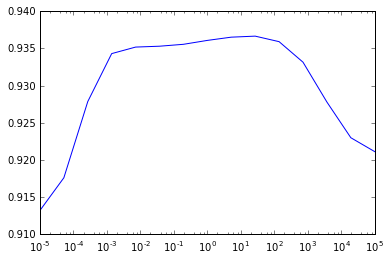

In [39]:
plt.semilogx(i_vals, scores)

In [40]:
las = sklearn.linear_model.Ridge(alpha=10**1.2)
las.fit(X_train, y_train)
las.coef_[las.coef_>0.1]

array([ 0.15226436,  0.15072471,  0.10916788,  0.15002856,  0.16908688,
        0.25712769,  0.21524714,  0.11246947,  0.10114922,  0.20544133,
        0.17035783,  0.18583085,  0.16372963,  0.15018835,  0.12549465,
        0.1458065 ,  0.10671399,  0.17709466,  0.23800304,  0.1268617 ,
        0.16033101,  0.12940705,  0.17949194,  0.26739105,  0.30407336,
        0.40639366,  0.15370951,  0.14683242,  0.17530052,  0.10247068,
        0.15497901,  0.10044886,  0.14355698,  0.12455189,  0.16635861,
        0.11207668,  0.15263938,  0.15528993,  0.10455303,  0.15253731,
        0.14704764,  0.1869904 ,  0.10928947,  0.15151599,  0.22050327,
        0.17327239,  0.16889622,  0.19547529,  0.11370969,  0.17209553,
        0.16059449,  0.11775123,  0.10850395,  0.19484427])

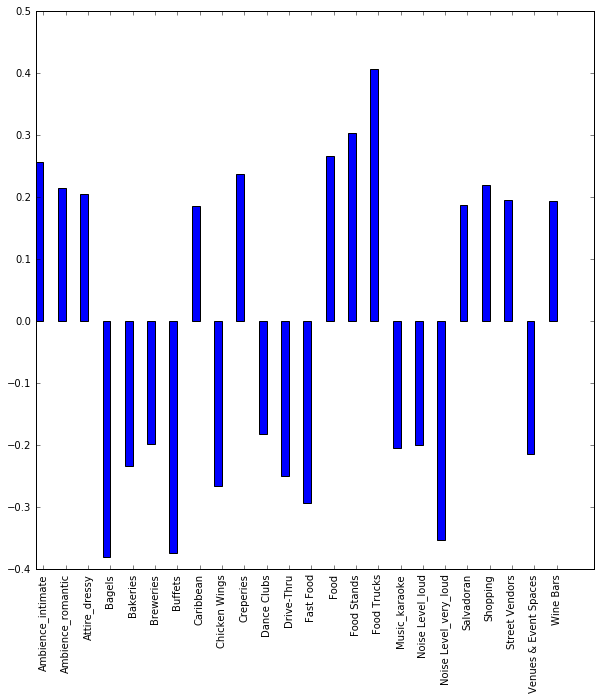

In [41]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
thresh = 0.18
selected_coef = (las.coef_ > thresh)|(las.coef_ < -thresh)
ind = np.arange(len(las.coef_[selected_coef]))
width = 0.35
ax.bar(ind, las.coef_[selected_coef], width)
ax.set_xticks(ind + width)
ax.set_xticklabels(x.columns[selected_coef])
plt.setp(ax.get_xticklabels(), rotation=90, fontsize=10)
plt.show()

## Content based filtering

In [113]:
# X_train, X_test, y_train, y_test = train_test_split(
#     phoenix_update.drop('stars', axis=1), phoenix_update['stars'].values, test_size=0.3, random_state=0)
# print 'Train shape: ', X_train.shape
# print 'Test shape: ', X_test.shape
# phoenix_update['business_id'].shape
# X_train['business_id'].isin(X_test['business_id'])
# phoenix_update[phoenix_update['business_id'].isin(phoenix_update['business_id'].unique())].shape
phoenix_restaurants.shape

(10182, 10)

In [45]:
x_train = pd.merge(reviews_train, phoenix_update, how='inner', on='business_id')
x_test = pd.merge(reviews, X_test, how='inner', on='business_id')

y_train = x_train['stars']
y_test = x_test['stars']

x_train.drop('stars', axis=1)
x_test.drop('stars', axis=1)

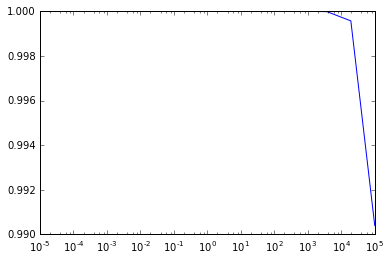

In [47]:
scores = []
i_vals = np.logspace(-5,5,15)
for i in i_vals:
    las = sklearn.linear_model.Ridge(alpha=i)
    las.fit(x_train, y_train)
    scores.append(las.score(x_test, y_test))
plt.semilogx(i_vals, scores)

In [48]:
las = sklearn.linear_model.Ridge(alpha=10**4)
las.fit(x_train, y_train)

Ridge(alpha=10000, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [52]:
np.sqrt(sklearn.metrics.mean_squared_error(y_test, las.predict(x_test)))
# np.sum((las.predict(x_test) - y_test)**2/float(len(y_test)))

0.014896439325708433

In [53]:
las.predict(x_test)

array([ 3.99403956,  3.99403956,  3.99403956, ...,  3.99971784,
        4.98952876,  4.98892126])

In [54]:
y_test

0         4
1         4
2         4
3         4
4         4
5         4
6         4
7         4
8         4
9         4
10        4
11        4
12        4
13        4
14        4
15        4
16        4
17        4
18        4
19        4
20        4
21        4
22        4
23        4
24        4
25        4
26        4
27        4
28        4
29        4
         ..
211305    4
211306    4
211307    2
211308    4
211309    4
211310    1
211311    4
211312    4
211313    3
211314    5
211315    1
211316    4
211317    4
211318    2
211319    5
211320    2
211321    5
211322    4
211323    1
211324    5
211325    5
211326    5
211327    4
211328    4
211329    2
211330    5
211331    4
211332    4
211333    5
211334    5
Name: stars, dtype: int64